In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [6]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]

### Varying bin sizes

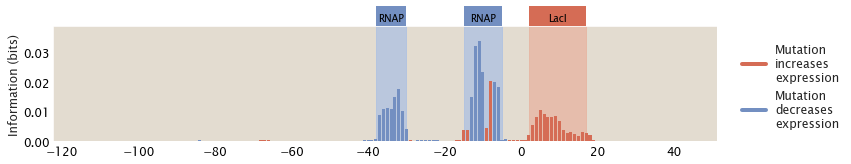

In [7]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2)

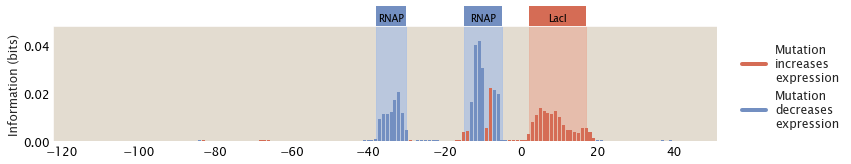

In [8]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=3)

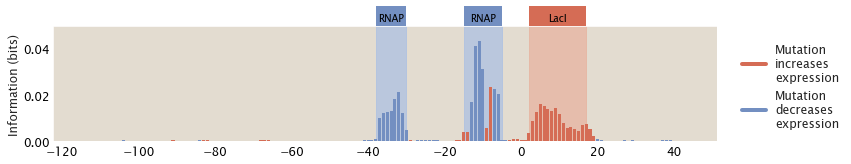

In [9]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=4)

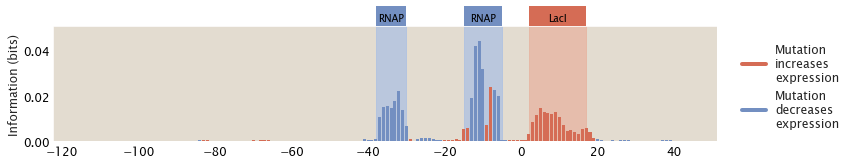

In [10]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=4, up_scaling_factor=1.5)

### Using ACGT instead of wild-type vs. mutant

In [11]:
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

In [12]:
n_seqs = len(mut_list)
len_promoter = 160
nbins = 2
upper_bound = np.mean(mu_data)
pseudocount = 10**(-6)

mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)

In [13]:
letters = ['A', 'T', 'C', 'G']

list_p_b = []
for position in range(len_promoter):
    dict_cnt = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
    for mut in mut_list:
        mut = mut.upper()
        letter = mut[position]
        dict_cnt[letter] += 1
    list_cnt = []
    for letter in letters:
        list_cnt.append(dict_cnt[letter])
    p_b = np.asarray(list_cnt) / n_seqs
    list_p_b.append(p_b)

In [14]:
list_joint_p = []
for position in range(len_promoter):
    joint_p = np.zeros((4, nbins)) + pseudocount
    # adding a pseudocount to prevent zero-division error
    for i, mut in enumerate(mut_list):
        mut = mut.upper()
        for j in range(nbins):
            for i_letter in range(4):
                if (mut[position] == letters[i_letter]) & (mu_bins[i] == j):
                    joint_p[i_letter][j] += 1

    joint_p /= np.sum(joint_p)
    list_joint_p.append(joint_p)

In [15]:
footprint = []
for position in range(len_promoter):
    p_b = list_p_b[position]
    joint_p = list_joint_p[position]

    mi = 0
    for i in range(len(p_mu)):
        for i_letter in range(4):
            mi += joint_p[i_letter][i] * np.log2(joint_p[i_letter][i] / (p_b[i_letter] * p_mu[i]))
    footprint.append(mi)

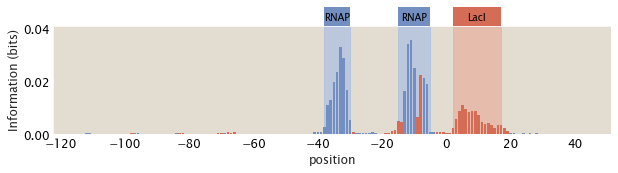

In [16]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter, smoothed=True, windowsize=windowsize)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)

ax.set_ylim(top=max(footprint_smoothed)*1.15)
max_signal = max(footprint_smoothed)
for region in region_params:
    tregs.footprint.label_binding_site(ax, region[0], region[1], max_signal, region[2], region[3])

ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors, linewidth=0)
plt.show()